In [13]:
import pandas as pd
import os
import numpy as np
import fucs
import matplotlib.pyplot as plt
import matplotlib as mpl
import observe_norm
import config
from fucs import save_image
%load_ext autoreload
%autoreload 1
%aimport fucs
%aimport observe_norm
import torch
# %config InlineBackend.figure_format = 'svg'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
all_monthly_data = pd.DataFrame(columns = ['Stn_No', 'Year', 'Lat', 'Long', 'Precip'])
print(os.getcwd())
# 搜索路径下的所有文件
for file in os.listdir('E:\\D1\\f01\\data\\原始站点资料（有华南）'):
    # 过滤需要的年份和月份
    month_of_file = int(file[-6:-4])#月
    year_of_file = int(file[-10:-6])#年
    if file.endswith('.TXT') and year_of_file in range(1994, 2025):
        data = pd.read_csv('E:\\D1\\f01\\data\\原始站点资料（有华南）\\'+file, sep = '\\s+', 
                           header=None, usecols=[0,1,2,4,5,6,9], 
                           names=['Stn_No', 'Lat', 'Long', 'Year', 'Month', 'Day', 'Precip'], 
                           encoding='utf-8')
        data.Precip = data.Precip.replace([32700, 32766, 32001, 30001, 9999900], np.nan)
        monthly_precip = data.groupby(['Stn_No', 'Lat', 'Long', 'Month', 'Year']).Precip.sum().reset_index()
        all_monthly_data = pd.concat([all_monthly_data, monthly_precip])
        
# 计算每个站点的平均Precip
# average_precip = all_monthly_data.groupby(['Stn_No'])['Precip'].mean().reset_index()
# average_precip = average_precip.rename(columns={'Precip': 'avg_Precip'})
# all_monthly_data = all_monthly_data.fillna(0)
# 将average_precip合并到all_monthly_data
# all_monthly_data = pd.merge(all_monthly_data, average_precip, on='Stn_No', how='left')

# 计算每个站点每个时间点相对于平均值的变化
# all_monthly_data['anoma'] = (all_monthly_data['Precip'] - all_monthly_data['avg_Precip']) / all_monthly_data['avg_Precip']
all_monthly_data['Month'] = all_monthly_data['Month'].astype(int)  # 将 'Month' 列转为整数
all_monthly_data['time'] = pd.to_datetime(all_monthly_data[['Year', 'Month']].assign(DAY=1))
# all_monthly_data.drop(['Year', 'Month'], axis=1, inplace=True)
all_monthly_data['Precip'] = all_monthly_data['Precip']/10
site_month_avg = all_monthly_data.groupby(['Stn_No', 'Month'])['Precip'].mean().reset_index().rename(columns={'Precip': 'site_month_avg'})
all_monthly_data = pd.merge(all_monthly_data, site_month_avg, on=['Stn_No', 'Month'], how='left')
all_monthly_data['anoma'] = (all_monthly_data['Precip'] - all_monthly_data['site_month_avg']) / all_monthly_data['site_month_avg']
# all_monthly_data.to_csv(r'E:\D1\diffusion\my_models\my_model_data\observe_data24.csv', index=False)



e:\D1\diffusion\my_models\my_model


C:\Users\fired\AppData\Local\Temp\ipykernel_30912\3182140648.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_monthly_data = pd.concat([all_monthly_data, monthly_precip])


In [6]:
# 选择特定列
df_subset = all_monthly_data[['Stn_No', 'Lat', 'Long']]

# 基于Stn_No列去除重复值，保留唯一站点
df_unique = df_subset.drop_duplicates(subset='Stn_No', keep='first')
df_unique['Lat'] = df_unique['Lat'] / 100
df_unique['Long'] = df_unique['Long'] / 100

# 保存为position.csv文件
df_unique.to_csv(r'E:\D1\diffusion\my_models\my_model_data\position.csv', index=False)


C:\Users\fired\AppData\Local\Temp\ipykernel_30912\2582081221.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['Lat'] = df_unique['Lat'] / 100
C:\Users\fired\AppData\Local\Temp\ipykernel_30912\2582081221.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['Long'] = df_unique['Long'] / 100


In [ ]:
all_monthly_data.groupby('Stn_No')['anoma'].var()

In [ ]:
draw = all_monthly_data.query('Stn_No == 50137')
fig, ax = plt.subplots()
ax.plot(draw['Precip'])
plt.show()
print(draw['anoma'].sum())

In [ ]:
print(all_monthly_data)

In [23]:
result = pd.read_csv(r'E:\D1\diffusion\my_models\my_model_data\observe_data24.csv')
result['Long'] = result['Long']/100
result['Lat'] = result['Lat']/100

In [24]:
def filter_data_by_date(start_date, end_date, df, exclude_dates=None):
    # 创建日期序列
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
    
    # 将time列转换为datetime格式
    df['time'] = pd.to_datetime(df['time'])
    
    # 过滤数据
    filtered_df = df[df['time'].isin(date_range)]
    
    # 如果提供了exclude_dates参数，删除对应日期的数据
    if exclude_dates:
        exclude_dates = pd.to_datetime(exclude_dates)
        filtered_df = filtered_df[~filtered_df['time'].isin(exclude_dates)]
    
    return filtered_df


# 示例调用
start_date = '1994-01-01'
end_date = '2024-09-01'#'2011-09-01', '2011-10-01', '2017-01-01'
filtered_df = filter_data_by_date(start_date, end_date, result, exclude_dates=[])
print(filtered_df)

        Stn_No  Year    Lat    Long  Precip  Month       time  site_month_avg  \
0        50136  1994  53.28  122.22     6.2      1 1994-01-01        7.016129   
1        50246  1994  52.19  124.43     7.9      1 1994-01-01        5.225806   
2        50247  1994  52.03  123.40     4.9      1 1994-01-01        5.212903   
3        50349  1994  51.42  124.20     5.4      1 1994-01-01        4.541935   
4        50353  1994  51.43  126.39     6.7      1 1994-01-01        5.151613   
...        ...   ...    ...     ...     ...    ...        ...             ...   
887247   59948  2024  18.13  109.35   667.2      9 2024-09-01      311.151613   
887248   59951  2024  18.48  110.20   518.7      9 2024-09-01      390.270968   
887249   59954  2024  18.33  110.02   367.7      9 2024-09-01      330.061290   
887250   59981  2024  16.50  112.20   290.7      9 2024-09-01      260.003226   
887251   59985  2024  16.32  111.37   154.8      9 2024-09-01      249.529032   

           anoma  
0      -

In [25]:
grid_data = fucs.gred_time_site_to_net(df=filtered_df, to_xr=False, gred_var='anoma')
fucs.check_nan_status(grid_data)

there are NaNs in the dataframe
张量形状: (369, 120, 140)
有4236073个NaN，占总数的68.33%


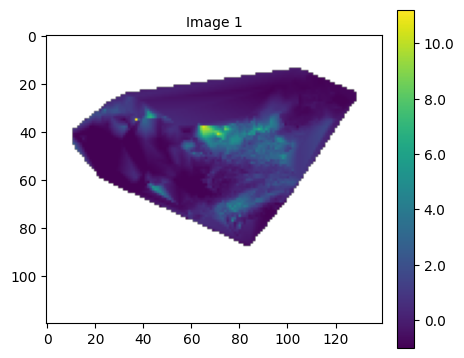

In [26]:
save_image(torch.tensor(grid_data)[262], show=True)

In [27]:
# Create sliding window dataset with window size 6 along the time dimension
window_size = 6
num_windows = grid_data.shape[0] - window_size + 1
sliding_window_data = np.zeros((num_windows, window_size, grid_data.shape[1], grid_data.shape[2]))

for i in range(num_windows):
    sliding_window_data[i] = grid_data[i:i+window_size]

print(f"New dataset shape: {sliding_window_data.shape}")
# Optionally save the new dataset
# np.save("E:/D1/diffusion/my_models/my_model_data/sliding_window_data.npy", sliding_window_data)

New dataset shape: (364, 6, 120, 140)


In [28]:
# Remove specific indices (212, 213, 276) along the first dimension of sliding_window_data
indices_to_remove = [212, 213, 276]
sliding_window_data = np.delete(sliding_window_data, indices_to_remove, axis=0)
print(f"Updated dataset shape after removal: {sliding_window_data.shape}")
# Optionally save the updated dataset
# np.save("E:/D1/diffusion/my_models/my_model_data/sliding_window_data_filtered.npy", sliding_window_data)

Updated dataset shape after removal: (361, 6, 120, 140)


In [29]:
np.save(os.path.join(config.modelconfig['hr_path'], 'hr_data1.npy'), sliding_window_data)

In [9]:
data_z = grid_data/10
data_z = np.clip(data_z, -1, 1)



In [10]:
normalizer1 = observe_norm.DataNormalizer()
normalizer1.fit(grid_data)
data_z = normalizer1.transform(grid_data)

In [10]:
np.save("E:\D1\diffusion\my_models\my_model_data/hr_unetall/1.npy", data_z)

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\fired\AppData\Local\Temp\ipykernel_10680\3050524899.py:1: SyntaxWarning: invalid escape sequence '\D'
  np.save("E:\D1\diffusion\my_models\my_model_data/hr_unetall/1.npy", data_z)


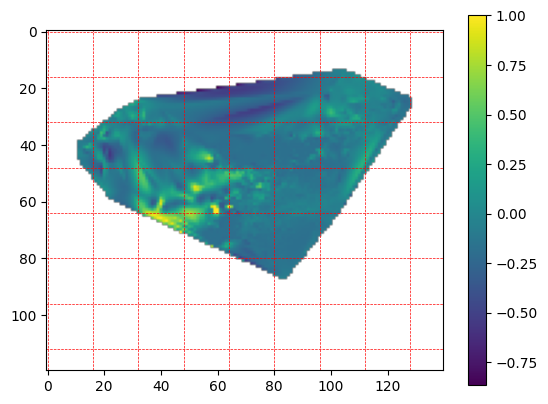

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 data_z 已经定义
# 绘制二维数组 data_z[6] 的图像
plt.imshow(np.array(data_z[0]), cmap='viridis')
plt.colorbar()  # 添加颜色条

# 获取图像的高度和宽度
height, width = np.array(data_z[6]).shape

# 在 x 为 32、64 等倍数的位置添加竖线
for x in range(0, width, 16):
    plt.axvline(x=x, color='r', linestyle='--', linewidth=0.5)

# 在 y 为 32、64 等倍数的位置添加横线
for y in range(0, height, 16):
    plt.axhline(y=y, color='r', linestyle='--', linewidth=0.5)

# plt.title('Image of data_z[6]')
plt.show()



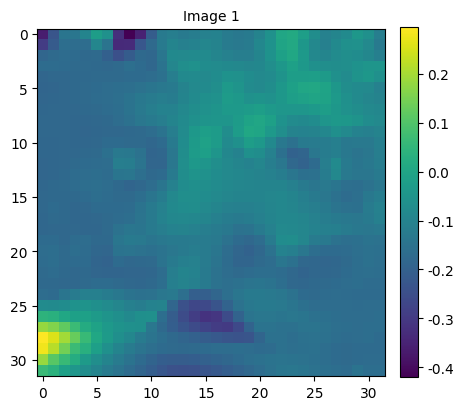

In [19]:
qqqdata = np.load(r"E:\D1\diffusion\my_models\my_model_data\hr4train\10_10.npy")
save_image(torch.tensor(qqqdata[0]), show=True)

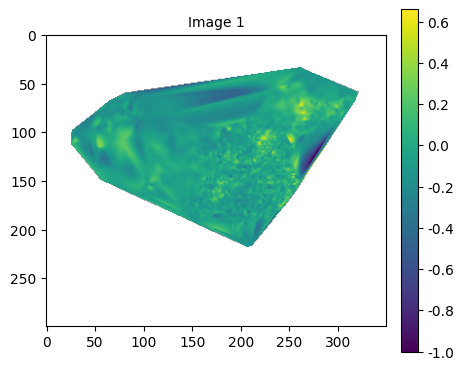

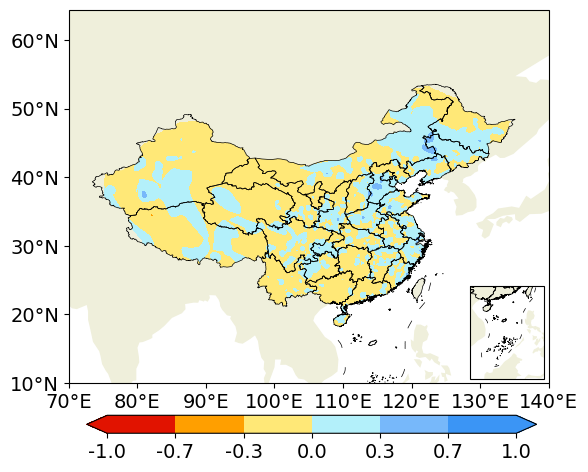

In [8]:
save_image(torch.tensor(data_z[6]), show=True)
fucs.draw_rainfall_map(data_z[6], min=-1, max=1)


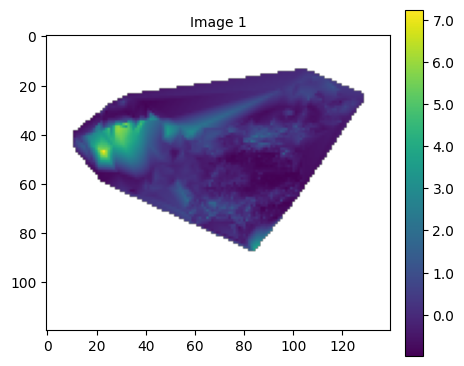

In [9]:
save_image(torch.tensor(grid_data[20]), show=True)
# fucs.draw_rainfall_map(grid_data[6], min=-1, max=1)

In [8]:
np.save(r"E:/D1/diffusion/my_models/mulNet_data/hr_data1.npy", grid_data)

In [26]:
grid_data = data_z

In [37]:
np.sum(grid_data > 25)

np.int64(595)

In [46]:
less_than_zero = np.sum(grid_data < 0)
equal_to_zero = np.sum(grid_data == 0)
greater_than_zero = np.sum(grid_data > 0)
nan_count = np.sum(np.isnan(grid_data))  # 统计 NaN 的数量
total_values = grid_data.size

# 计算占比
less_than_zero_ratio = less_than_zero / total_values
equal_to_zero_ratio = equal_to_zero / total_values
greater_than_zero_ratio = greater_than_zero / total_values
nan_ratio = nan_count / total_values  # 计算 NaN 的占比

print(f"小于零的值数量: {less_than_zero}, 占比: {less_than_zero_ratio * 100:.2f}%")
print(f"等于零的值数量: {equal_to_zero}, 占比: {equal_to_zero_ratio * 100:.2f}%")
print(f"大于零的值数量: {greater_than_zero}, 占比: {greater_than_zero_ratio * 100:.2f}%")
print(f"NaN 的数量: {nan_count}, 占比: {nan_ratio * 100:.2f}%")

小于零的值数量: 425998, 占比: 19.32%
等于零的值数量: 0, 占比: 0.00%
大于零的值数量: 266834, 占比: 12.10%
NaN 的数量: 1512168, 占比: 68.58%


In [6]:
print(np.nanmean(grid_data))
print(np.nanstd(grid_data))
print(np.nanmin(grid_data))
print(np.nanmax(grid_data))


0.0021031631707219807
0.929048869919935
-1.0000000000000004
24.635361901332157


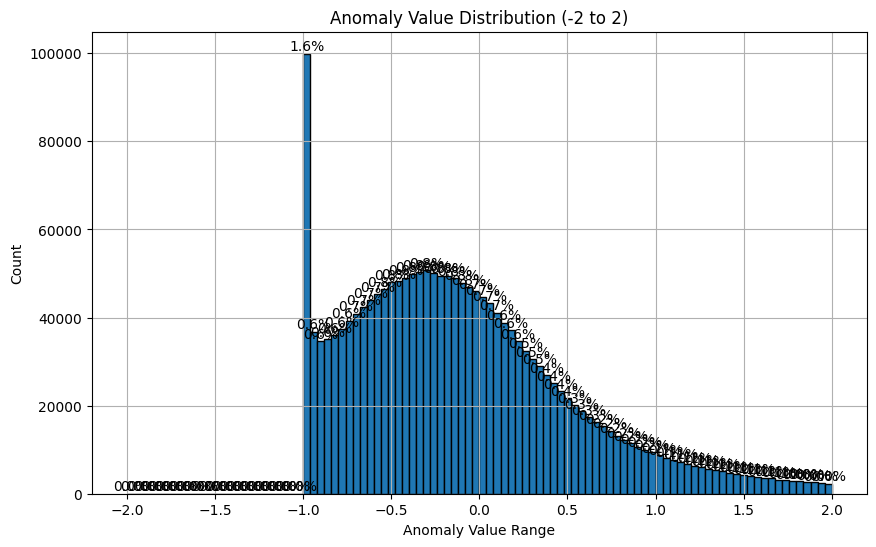

In [5]:
fucs.plot_anomaly_distribution(grid_data, -2, 2, 100)


In [17]:
print(np.nanmean(data_z), np.nanstd(data_z))
print(np.nanmean(grid_data), np.nanstd(grid_data))
print(np.nanmin(grid_data))
print(np.nanmax(grid_data))


-0.00791955 0.2526614
0.018001882824153454 1.8861640632369312
-90.48875880818264
87.17977974641481


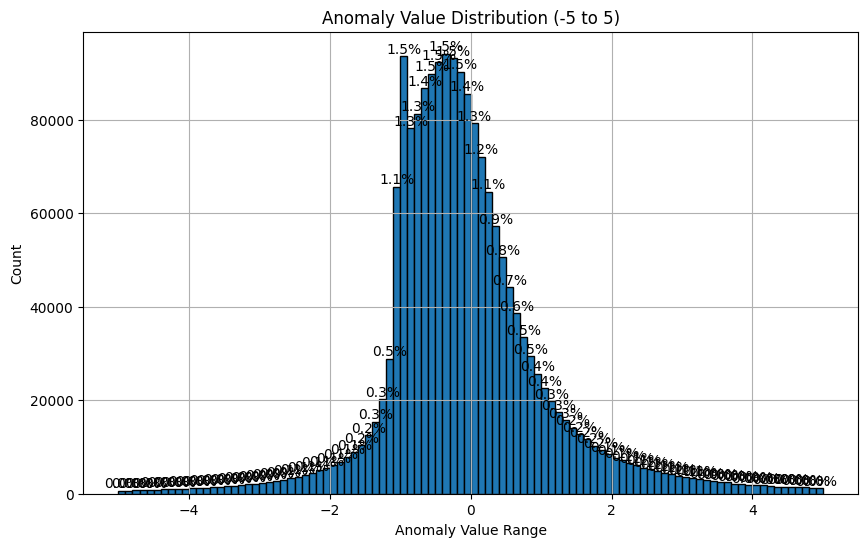

In [14]:
fucs.plot_anomaly_distribution(grid_data, -5, 5, 100)


In [46]:
print(np.nanmean(data_z2), np.nanstd(data_z2))


-0.2287393 0.27017596


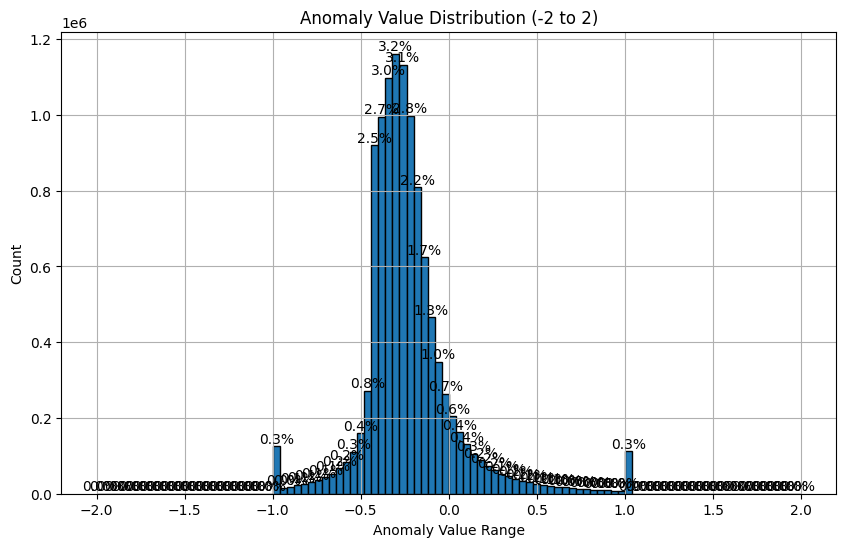

In [34]:
fucs.plot_anomaly_distribution(data_z2, -2, 2, 100)

In [ ]:
nth_grid_data  = grid_data[1]

In [ ]:
print(grid_data.shape)

In [ ]:
print(len(grid_data[np.isnan(grid_data)]))
print(grid_data.size)
print((len(grid_data[np.isnan(grid_data)])) / (grid_data.size))
print(grid_data.shape)

In [26]:
size_per_image = 32
x_list = np.arange(0, 350-size_per_image, 16)
y_list = np.arange(0, 300-size_per_image, 16)

In [27]:
for y_id, y in enumerate(y_list):
    for x_id, x in enumerate(x_list):
        sub_image = grid_data[:, y:y+size_per_image, x:x+size_per_image]
        # save_image(torch.from_numpy(sub_image), show=True)
        np.save('E:\D1\diffusion\my_models\my_model_data\hr_images3/'+str(x_id)+'_'+str(y_id)+'.npy', sub_image)


<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
C:\Users\fired\AppData\Local\Temp\ipykernel_56964\2213560822.py:5: SyntaxWarning: invalid escape sequence '\D'
  np.save('E:\D1\diffusion\my_models\my_model_data\hr_images3/'+str(x_id)+'_'+str(y_id)+'.npy', sub_image)


In [49]:
hr_dir = 'E:\D1\diffusion\my_models\my_model_data\hr_images/'
lr_dir = 'E:\D1\diffusion\my_models\my_model_data\lr_images/'

# 读取lr_dir下的文件名为列表
lr_files = [f for f in os.listdir(lr_dir) if os.path.isfile(os.path.join(lr_dir, f))]

# 获取hr_dir下所有文件
hr_files = [f for f in os.listdir(hr_dir) if os.path.isfile(os.path.join(hr_dir, f))]

# 删除hr_dir下所有列表以外的文件
for hr_file in hr_files:
    if hr_file not in lr_files:
        os.remove(os.path.join(hr_dir, hr_file))
        print(f"Deleted: {hr_file} from {hr_dir}")

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\fired\AppData\Local\Temp\ipykernel_2968\285158545.py:1: SyntaxWarning: invalid escape sequence '\D'
  hr_dir = 'E:\D1\diffusion\my_models\my_model_data\hr_images/'
C:\Users\fired\AppData\Local\Temp\ipykernel_2968\285158545.py:2: SyntaxWarning: invalid escape sequence '\D'
  lr_dir = 'E:\D1\diffusion\my_models\my_model_data\lr_images/'


In [ ]:
def show_nth_image(grid_data, n, x_list, y_list):
    # 取出第n张图
    image = grid_data[n]
    nan_mask = np.isnan(image)
    masked_image = np.ma.masked_where(nan_mask, image)
    cmap1 = mpl.colors.ListedColormap(['#E11300', '#FF3100', '#FF9F00', '#FFBF3B', '#FFE877','#B3F0FA', '#95D2FA', '#77B8FA', '#4FA4F5', '#3B95F5'])#冷大
    # 获取当前的坐标轴
    ax = plt.gca()
    # 指定 ax 参数来创建颜色条
    plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap1), orientation='vertical', ax=ax)
    # 使用matplotlib画出图像
    plt.imshow(masked_image)
    
    # plt.colorbar(cmap=cmap1)
    plt.imshow(nan_mask, cmap='Reds', alpha=0)
    # plt.show()

    for x in x_list:
        plt.axvline(x=x, color='r')
        plt.axvline(x=x+32, color='b')

    for y in y_list:
        plt.axhline(y=y, color='r')
        plt.axhline(y=y+32, color='b')


    plt.show()

# 假设你要取出第5张图，你可以这样调用这个函数
show_nth_image(grid_data, 5, x_list, y_list)


# # 假设你要取出第5张图，你可以这样调用这个函数
# show_nth_image(grid_data, 5, x_list, y_list)

In [ ]:
save_image(torch.from_numpy(grid_data[0]), show=True)

In [ ]:
fucs.draw_rainfall_map(grid_data[0])

In [30]:
import os
import numpy as np

# 定义数据目录
hr_dir = 'E:/D1/diffusion/my_models/my_model_data/hr_images3'
lr_dir = 'E:/D1/diffusion/my_models/my_model_data/lr_images3'

# 遍历hr_images2目录下的所有npy文件
for filename in os.listdir(hr_dir):
    if filename.endswith('.npy'):
        # 构建文件的完整路径
        hr_file_path = os.path.join(hr_dir, filename)
        lr_file_path = os.path.join(lr_dir, filename)

        # 加载npy文件
        data = np.load(hr_file_path)

        # 检查文件是否全为NaN
        if np.all(np.isnan(data)):
            # 删除hr_images2下的文件
            os.remove(hr_file_path)
            print(f"已删除文件: {hr_file_path}")

            # 删除lr_images2下的对应文件
            if os.path.exists(lr_file_path):
                os.remove(lr_file_path)
                print(f"已删除文件: {lr_file_path}")

# ... existing code ...


已删除文件: E:/D1/diffusion/my_models/my_model_data/hr_images3\0_0.npy
已删除文件: E:/D1/diffusion/my_models/my_model_data/lr_images3\0_0.npy
已删除文件: E:/D1/diffusion/my_models/my_model_data/hr_images3\0_1.npy
已删除文件: E:/D1/diffusion/my_models/my_model_data/lr_images3\0_1.npy
已删除文件: E:/D1/diffusion/my_models/my_model_data/hr_images3\0_10.npy
已删除文件: E:/D1/diffusion/my_models/my_model_data/lr_images3\0_10.npy
已删除文件: E:/D1/diffusion/my_models/my_model_data/hr_images3\0_11.npy
已删除文件: E:/D1/diffusion/my_models/my_model_data/lr_images3\0_11.npy
已删除文件: E:/D1/diffusion/my_models/my_model_data/hr_images3\0_12.npy
已删除文件: E:/D1/diffusion/my_models/my_model_data/lr_images3\0_12.npy
已删除文件: E:/D1/diffusion/my_models/my_model_data/hr_images3\0_13.npy
已删除文件: E:/D1/diffusion/my_models/my_model_data/lr_images3\0_13.npy
已删除文件: E:/D1/diffusion/my_models/my_model_data/hr_images3\0_14.npy
已删除文件: E:/D1/diffusion/my_models/my_model_data/lr_images3\0_14.npy
已删除文件: E:/D1/diffusion/my_models/my_model_data/hr_images3\0_15.npy

In [ ]:
image = grid_data[5]
image  = np.nan_to_num(image, nan=-255)
fft2_result = np.fft.fft2(image)

# 获取二维信号的频谱
magnitude_spectrum = 20 * np.log(np.abs(fft2_result))

# 显示频谱
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('FFT Magnitude')
plt.show()

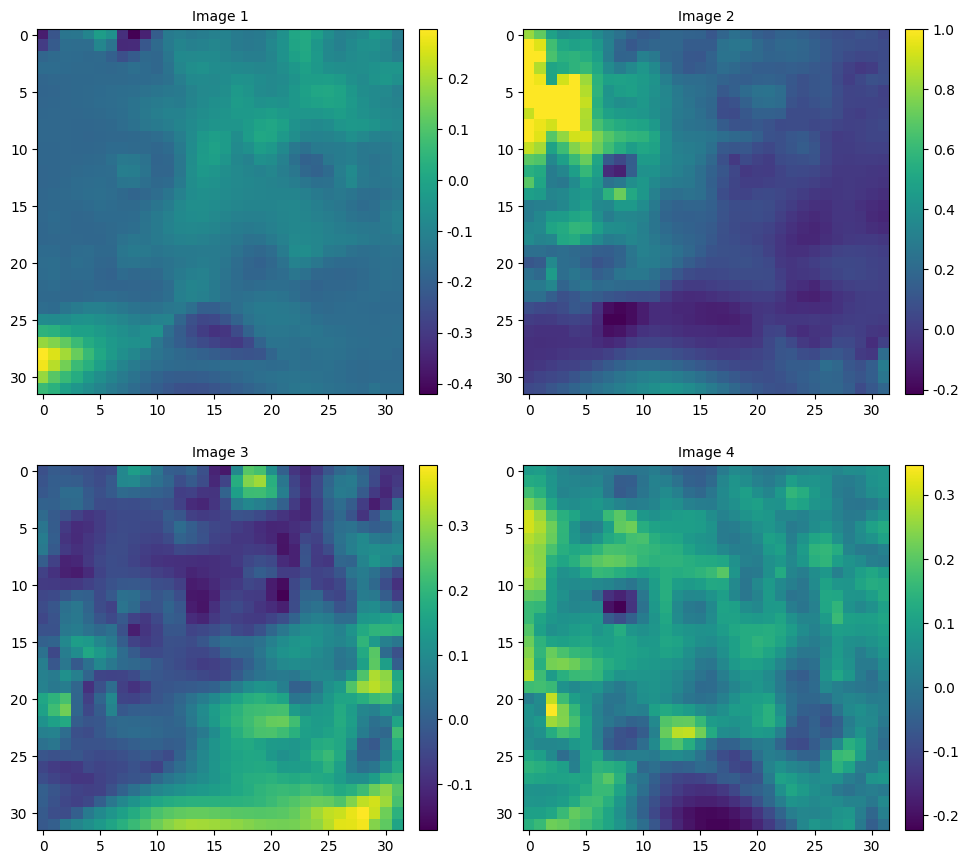

In [12]:
import numpy as np
import fucs
import torch
data = np.load(r"E:\D1\diffusion\my_models\my_model_data\hr_images\10_10.npy")
dataT = torch.tensor(data)
fucs.save_image(dataT[0], dataT[2], dataT[6], dataT[100], show=True)
